# Commodity crack spread statistical arbitrage

In this notebook, the mean-rereversion strategy proposed in Girma and Paulson 1999 (henthforth GP1999) is investigated. It focuses on a various combination of the crude oil (WTI) crack spread. 

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import BacktestEngine, signal, InstrumentDef
from vivace.backtest.analytics import rebase
from vivace.backtest.contract import get_futures_curve_snapshot
from vivace.backtest.enums import Strategy, Weighting, RollRule
from vivace.backtest.stats import Performance

# Cointegration test

GP1999 first checks if the crack spread is cointegrated. To do that, first let's see futures prices are non-stationary or not. As per usual, the generic price is populated by running a simple long-only backtest by rolling the front contract.

## ADF test

The ADF test is done by the `adfuller` function in `statsmodels`. (cf. https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [2]:
cl_1st = BacktestEngine(instrument='CL', log_level=logging.WARN)
cl_1st.run()

In [3]:
ho_1st = BacktestEngine(instrument='HO', log_level=logging.WARN)
ho_1st.run()

In [4]:
xb_1st = BacktestEngine(instrument='XB', log_level=logging.WARN)
xb_1st.run()

In [5]:
cl_price = cl_1st.get_generic_price().squeeze().fillna(method='pad').rename('Crude oil')
ho_price = ho_1st.get_generic_price().squeeze().fillna(method='pad').rename('Heating oil')
xb_price = xb_1st.get_generic_price().squeeze().fillna(method='pad').rename('Gasoline')

In [6]:
def adf(ts: pd.Series, **kwargs) -> pd.Series:
    """ Run the ADF test and return a cleaned result """
    adf_result = sm.tsa.stattools.adfuller(ts, **kwargs)
    cleaned = {
        'adf': adf_result[0],
        'p_value': adf_result[1],
        'used_lag': adf_result[2],
        'n_obs': adf_result[3],
        'ci_0.01': adf_result[4]['1%'],
        'ci_0.05': adf_result[4]['5%'],
        'ci_0.1': adf_result[4]['10%'],
        'ic_best': adf_result[5],
    }
    return pd.Series(cleaned, name=ts.name)

GP1999 uses Schwarz's information criterion (i.e., BIC) to select the optimal number of lags included in the ADF test.

In [7]:
adf_result = pd.concat((
    adf(cl_price['1983-04':'1994-11'], autolag='BIC').to_frame().T,
    adf(ho_price['1983-04':'1994-11'], autolag='BIC').to_frame().T,
    adf(xb_price['1984-12':'1994-11'], autolag='BIC').to_frame().T,
))

In the ADF test, $H_0$ is that the time-series is non-stationary. Based on this result below, $H_0$ cannot be rejected for crude oil, however is rejected for heating oil and gasoline at the 10% and 5% level respectively.

This is interesting because usually almost always asset prices are non-stationary.

In [8]:
adf_result

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
Crude oil,-2.185213,0.211656,8.0,2924.0,-3.432588,-2.862529,-2.567296,4195.186424
Heating oil,-2.743636,0.066787,3.0,2929.0,-3.432585,-2.862527,-2.567296,-15763.929006
Gasoline,-3.003758,0.034545,3.0,2510.0,-3.432958,-2.862692,-2.567383,-14006.551367


Probably it is to do with the sampling period. It may look a stationary process especially after 1986, however clearly it is heteroskedastic and the price move in 1986 seems like a shift in the level.

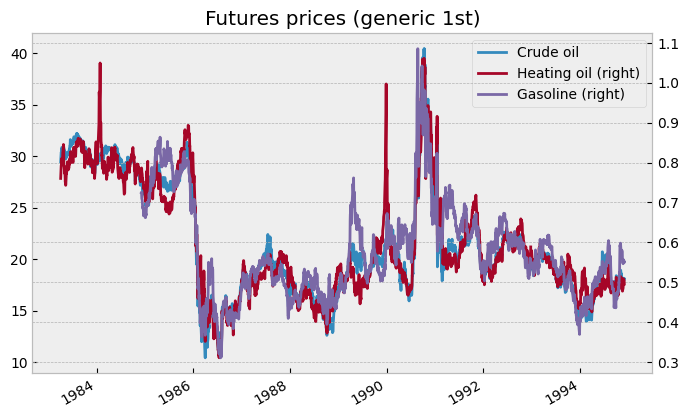

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
pd.concat((
    cl_price['1983-04':'1994-11'],
    ho_price['1983-04':'1994-11'],
    xb_price['1984-12':'1994-11'],
), axis=1).plot(secondary_y=['Heating oil', 'Gasoline'], ax=ax);
ax.set_title('Futures prices (generic 1st)');

In fact, in the long-run $H_0$ cannot be rejected for all contracts based on both BIC and AIC.

In [10]:
pd.concat((
    adf(cl_price['1983-04':], autolag='BIC').to_frame().T,
    adf(ho_price['1983-04':], autolag='BIC').to_frame().T,
    adf(xb_price['1984-12':], autolag='BIC').to_frame().T,
))

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
Crude oil,-1.837543,0.361988,1.0,9979.0,-3.431005,-2.861830,-2.566924,31528.043271
Heating oil,-1.350297,0.605859,6.0,9975.0,-3.431006,-2.861830,-2.566924,-37104.575846
Gasoline,-2.055800,0.262655,0.0,9561.0,-3.431034,-2.861842,-2.566931,-35691.675295


In [11]:
pd.concat((
    adf(cl_price['1983-04':], autolag='AIC').to_frame().T,
    adf(ho_price['1983-04':], autolag='AIC').to_frame().T,
    adf(xb_price['1984-12':], autolag='AIC').to_frame().T,
))

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
Crude oil,-2.328245,0.163020,38.0,9942.0,-3.431008,-2.861831,-2.566925,31424.050262
Heating oil,-1.676228,0.443400,36.0,9945.0,-3.431008,-2.861831,-2.566925,-37263.002254
Gasoline,-2.366357,0.151458,26.0,9535.0,-3.431036,-2.861843,-2.566931,-35745.821283


Test for two unit roots shows the $H_0$ is rejected for all assets so it would be safe to assume prices are all $I(1)$ processes.

In [12]:
pd.concat((
    adf(cl_price['1983-04':'1994-11'].diff().dropna(), autolag='BIC').to_frame().T,
    adf(ho_price['1983-04':'1994-11'].diff().dropna(), autolag='BIC').to_frame().T,
    adf(xb_price['1984-12':'1994-11'].diff().dropna(), autolag='BIC').to_frame().T,
))

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
Crude oil,-22.609167,0.0,7.0,2924.0,-3.432588,-2.862529,-2.567296,4191.382386
Heating oil,-23.732562,0.0,7.0,2924.0,-3.432588,-2.862529,-2.567296,-15759.438574
Gasoline,-31.046797,0.0,2.0,2510.0,-3.432958,-2.862692,-2.567383,-13998.959272


## Engle-Granger test

Next, let's check if the crack spread is cointegrated. The cointegration vector is estimated by OLS and the stationarity of the residual is tested with the ADF test.
The test is done by the `coint` function in `statsmodels`. (cf. https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html)

In [13]:
price_concat = pd.concat((
    cl_price,
    ho_price,
    xb_price,
), axis=1).fillna(method='pad').dropna()

In [14]:
def coint(y: pd.Series, x: pd.DataFrame) -> pd.Series:
    """ Run the cointegration test and return a cleaned result """
    result = sm.tsa.stattools.coint(y, x)
    cleaned = {
        't_value': result[0],
        'p_value': result[1],
        'ci_0.01': result[2][0],
        'ci_0.05': result[2][1],
        'ci_0.1': result[2][2],
    }
    return pd.Series(cleaned)

In [15]:
coint_result = pd.concat((
    coint(
        price_concat.loc[:'1994-11', 'Crude oil'],
        price_concat.loc[:'1994-11', ['Heating oil', 'Gasoline']]
    ).to_frame('CL vs HO + XB').T,
    coint(
        price_concat.loc[:'1994-11', 'Crude oil'],
        price_concat.loc[:'1994-11', ['Gasoline']]
    ).to_frame('CL vs XB').T,
    coint(
        price_concat.loc[:'1994-11', 'Crude oil'],
        price_concat.loc[:'1994-11', ['Heating oil']]
    ).to_frame('CL vs HO').T,
))

The $H_0$ is that there is no cointegration. As per GP1999, all three crack spreads are cointegrated. 

In [16]:
coint_result

,t_value,p_value,ci_0.01,ci_0.05,ci_0.1
CL vs HO + XB,-6.110715,0.000005,-4.299485,-3.744067,-3.454651
CL vs XB,-5.762029,0.000005,-3.900800,-3.338561,-3.046137
CL vs HO,-5.708354,0.000007,-3.900800,-3.338561,-3.046137


This seems to hold with the full sample.

In [17]:
pd.concat((
    coint(
        price_concat.loc[:, 'Crude oil'],
        price_concat.loc[:, ['Heating oil', 'Gasoline']]
    ).to_frame('CL vs HO + XB').T,
    coint(
        price_concat.loc[:, 'Crude oil'],
        price_concat.loc[:, ['Gasoline']]
    ).to_frame('CL vs XB').T,
    coint(
        price_concat.loc[:, 'Crude oil'],
        price_concat.loc[:, ['Heating oil']]
    ).to_frame('CL vs HO').T,
))

,t_value,p_value,ci_0.01,ci_0.05,ci_0.1
CL vs HO + XB,-4.840255,1.443506e-03,-4.295250,-3.741555,-3.452830
CL vs XB,-6.896633,1.509021e-08,-3.897585,-3.336769,-3.044893
CL vs HO,-3.445403,3.755198e-02,-3.897585,-3.336769,-3.044893


However the confidence level is somewhat weakend with recent data although they are at least still cointegrated at the 5% level.

In [18]:
pd.concat((
    coint(
        price_concat.loc['2010':, 'Crude oil'],
        price_concat.loc['2010':, ['Heating oil', 'Gasoline']]
    ).to_frame('CL vs HO + XB').T,
    coint(
        price_concat.loc['2010':, 'Crude oil'],
        price_concat.loc['2010':, ['Gasoline']]
    ).to_frame('CL vs XB').T,
    coint(
        price_concat.loc['2010':, 'Crude oil'],
        price_concat.loc['2010':, ['Heating oil']]
    ).to_frame('CL vs HO').T,
))

,t_value,p_value,ci_0.01,ci_0.05,ci_0.1
CL vs HO + XB,-4.027234,0.022761,-4.298159,-3.743281,-3.454081
CL vs XB,-4.657641,0.000667,-3.899793,-3.338000,-3.045748
CL vs HO,-2.563907,0.251634,-3.899793,-3.338000,-3.045748


## Crack spreads

Additionally, GP1999 tests the stationarity of the popularly traded crack spread -- 3:2:1 crack spread (CS), 1:1:0 gasoline crack spread (GCS) and 1:0:1 heating oil crack spread (HOCS).

Note that the crude oil contract is priced in barrels while the other two are priced in gallon, and there are 42 gallons per 1 barrel. Some unit conversions are required to calculate such spreads.

In [19]:
cs = (price_concat['Heating oil'].mul(42).mul(2 / 3) + 
      price_concat['Gasoline'].mul(42).mul(1 / 3) - 
      price_concat['Crude oil'])
gcs = (price_concat['Gasoline'].mul(42) - 
       price_concat['Crude oil'])
hocs = (price_concat['Heating oil'].mul(42) - 
        price_concat['Crude oil'])

As can be seen visually below, these spreads appear stationary until around 2000 after which they started to drift away from a certain level. This could be related to the financialisation of commodities. There are some evidence suggesting that index investments and speculative trades influence the commodity markets. (cf https://www.ecb.europa.eu/pub/financial-stability/fsr/focus/2011/pdf/ecb~6fdfdfce1c.fsrbox201112_04.pdf)

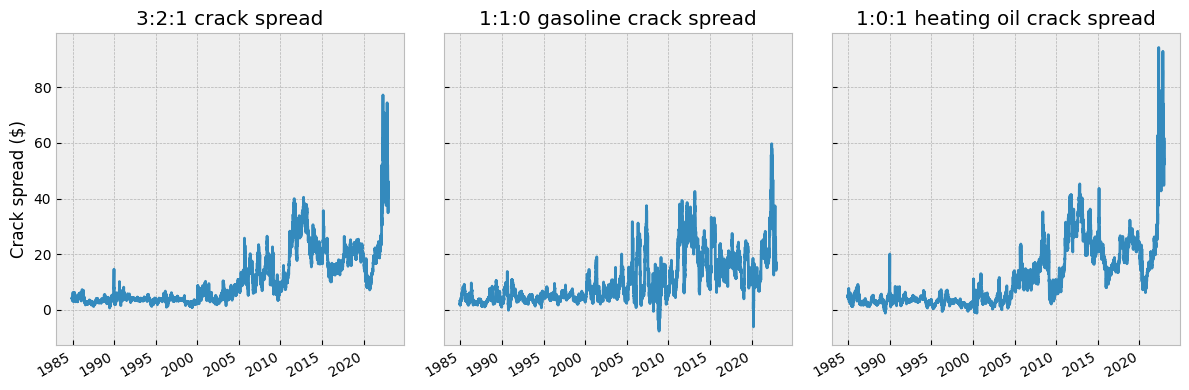

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
cs.plot(ax=ax[0])
gcs.plot(ax=ax[1])
hocs.plot(ax=ax[2])

ax[0].set_title('3:2:1 crack spread')
ax[1].set_title('1:1:0 gasoline crack spread')
ax[2].set_title('1:0:1 heating oil crack spread')
ax[0].set_ylabel('Crack spread ($)')

fig.tight_layout();

More formally, the ADF tests below show that they were stationary until Nov-1994.

In [21]:
pd.concat((
    adf(cs[:'1994-11'], autolag='BIC').to_frame().T,
    adf(gcs[:'1994-11'], autolag='BIC').to_frame().T,
    adf(hocs[:'1994-11'], autolag='BIC').to_frame().T,
))

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
0,-7.926287,3.611421e-12,0.0,2515.0,-3.432953,-2.86269,-2.567382,1757.165999
0,-5.640046,1.041538e-06,1.0,2514.0,-3.432954,-2.86269,-2.567382,2505.871051
0,-6.999952,7.365777e-10,0.0,2515.0,-3.432953,-2.86269,-2.567382,2815.457971


Statistically though these spreads are still stationary at the 1% confidence level even after 2000.

In [22]:
pd.concat((
    adf(cs['2000':], autolag='BIC').to_frame().T,
    adf(gcs['2000':], autolag='BIC').to_frame().T,
    adf(hocs['2000':], autolag='BIC').to_frame().T,
))

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
0,-3.201486,0.019899,3.0,5768.0,-3.431484,-2.862041,-2.567037,17360.705202
0,-5.417872,0.000003,0.0,5771.0,-3.431484,-2.862041,-2.567037,19018.541556
0,-3.187424,0.020724,2.0,5769.0,-3.431484,-2.862041,-2.567037,19449.346244


# Backtest

It's not entirely clear how many back contracts are used in the original analysis as they only mentioned they used *all spreads*. In this notebook, the first 6 contracts are used for the sake of simplicity. Beyond 6, there tends to be more missing prices because of inactivity.

In practice, one might want to consider liquidity of each contract to decide which one to trade as not all contract months have the same liquidity. In the case of crude oil, after certain points only June and December contracts are actually traded even though other months are listed.

In [23]:
cl_curve = get_futures_curve_snapshot('CL', datetime(2021, 12, 1), 'volume')

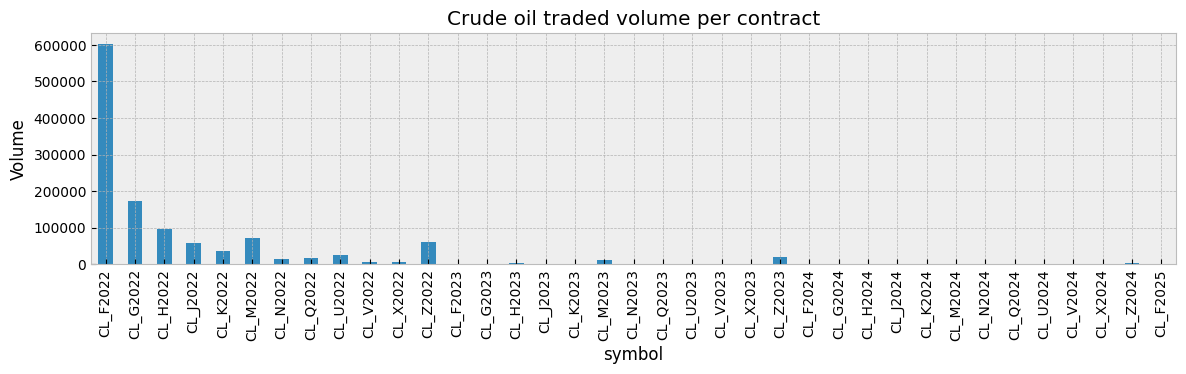

In [24]:
ax = cl_curve.loc[:'2024'].set_index('symbol')['volume'].plot(kind='bar', figsize=(14, 3));
ax.set_ylabel('Volume')
ax.set_title('Crude oil traded volume per contract');

## Crack spread

First define the instruments. `roll_rule` is defined to make sure futures are rolled on month-ends. As per the analysis done for crush spreads, some arbitrary collateral of 100k USD is used to meature futures returns.

In [25]:
max_expiry = 6
instrument = []
for i in range(1, max_expiry + 1):
    ho = InstrumentDef('HO', id=f'HO_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i)
    xb = InstrumentDef('XB', id=f'XB_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i)
    cl = InstrumentDef('CL', id=f'CL_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i)
    instrument.append(ho)
    instrument.append(xb)
    instrument.append(cl)

In [26]:
len(instrument)

18

In [27]:
engine_cs = BacktestEngine(
    start_date=datetime(1985, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    signal=signal.CrackSpreadGP1999(
        ma_lookback=5,
        entry_sigma=2,
    ),
    weighting=Weighting.SUM.value,
    log_level=logging.WARN,
)
engine_cs.run()

In [28]:
levels_cs = engine_cs.calculate_equity_curve(calculate_net=False).rename('Crack spread')

## Gasoline crack spread

In [29]:
max_expiry = 6
instrument = []
for i in range(1, max_expiry + 1):
    xb = InstrumentDef('XB', id=f'XB_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i)
    cl = InstrumentDef('CL', id=f'CL_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i)
    instrument.append(xb)
    instrument.append(cl)

In [30]:
engine_gcs = BacktestEngine(
    start_date=datetime(1985, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    signal=signal.CrackSpreadGP1999(
        weights={'XB': 42 * 1000, 'CL': -1 * 1000},
        ma_lookback=5,
        entry_sigma=2,
    ),
    weighting=Weighting.SUM.value,
    log_level=logging.WARN,
)
engine_gcs.run()

In [31]:
levels_gcs = engine_gcs.calculate_equity_curve(calculate_net=False).rename('Gasoline crack spread')

## Heating oil crack spread

In [32]:
max_expiry = 6
instrument = []
for i in range(1, max_expiry + 1):
    ho = InstrumentDef('HO', id=f'HO_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i)
    cl = InstrumentDef('CL', id=f'CL_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i)
    instrument.append(ho)
    instrument.append(cl)

In [33]:
engine_hocs = BacktestEngine(
    start_date=datetime(1985, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    signal=signal.CrackSpreadGP1999(
        weights={'HO': 42 * 1000, 'CL': -1 * 1000},
        ma_lookback=5,
        entry_sigma=2,
    ),
    weighting=Weighting.SUM.value,
    log_level=logging.WARN,
)
engine_hocs.run()

In [34]:
levels_hocs = engine_hocs.calculate_equity_curve(calculate_net=False).rename('Heating oil crack spread')

## Performance
During the sample period tested, a mean-reversion on the crack spread worked well.

In [35]:
levels = pd.concat((
    levels_cs, levels_gcs, levels_hocs
), axis=1)

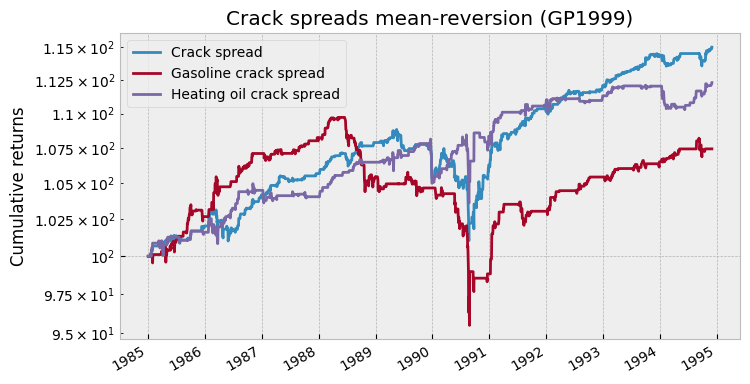

In [36]:
fig, ax = plt.subplots(figsize=(8, 4.5))
levels[:'1994-11'].plot(ax=ax, logy=True);
ax.set_title('Crack spreads mean-reversion (GP1999)')
ax.set_ylabel('Cumulative returns');

In [37]:
levels[:'1994-11'].pipe(Performance).summary()

,Crack spread,Gasoline crack spread,Heating oil crack spread
CAGR,0.014100,0.007241,0.011715
Annualised vol,0.018131,0.022948,0.017725
Sharpe ratio,0.777675,0.315525,0.660914
Max drawdown,0.071648,0.129760,0.044562
Calmar ratio,0.196791,0.055800,0.262889
Skewness,0.791950,4.373877,2.076780
Kurtosis,45.874931,200.909353,75.098364
Worst return,-0.012272,-0.022322,-0.013000
Worst 1d return,-0.012272,-0.022322,-0.013000
Worst 1w return,-0.018763,-0.034413,-0.019985


The underperformance in 1990 coincides with a wider divergence on the crack spread which is intuitive.

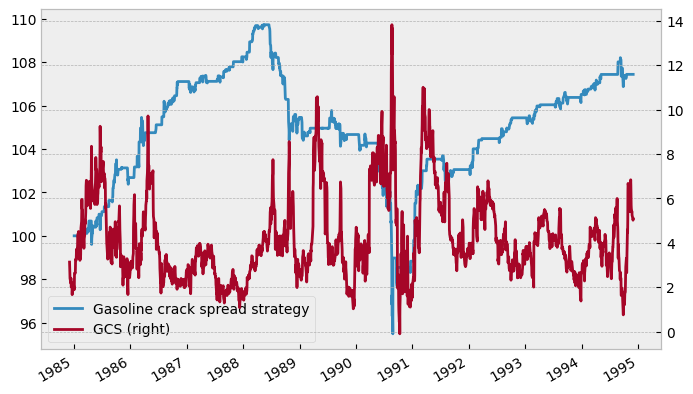

In [38]:
pd.concat((
    levels_gcs.rename('Gasoline crack spread strategy'),
    gcs.rename('GCS')
), axis=1)[:'1994-11'].plot(figsize=(8, 5), secondary_y='GCS');

## Long-term performance

...however as we saw earlier in the time-series of crack spreads, something must have changed in 2000s and the trading strategies stopped working.

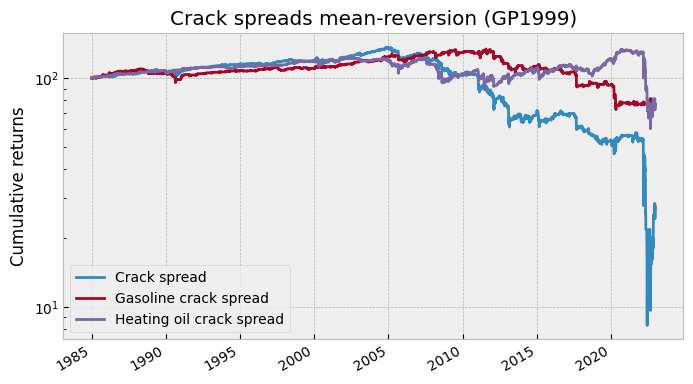

In [39]:
fig, ax = plt.subplots(figsize=(8, 4.5))
levels.plot(ax=ax, logy=True);
ax.set_title('Crack spreads mean-reversion (GP1999)')
ax.set_ylabel('Cumulative returns');

In [40]:
levels.pipe(Performance).summary()

,Crack spread,Gasoline crack spread,Heating oil crack spread
CAGR,-0.034284,-0.007326,-0.006992
Annualised vol,0.222714,0.047178,0.088165
Sharpe ratio,-0.153938,-0.155283,-0.079301
Max drawdown,0.939134,0.455942,0.550774
Calmar ratio,-0.036506,-0.016068,-0.012694
Skewness,14.399212,-0.819553,3.295203
Kurtosis,811.939551,71.948659,428.828844
Worst return,-0.339082,-0.049356,-0.162293
Worst 1d return,-0.339082,-0.049356,-0.162293
Worst 1w return,-0.487829,-0.101832,-0.129038


## Post publication

In [41]:
publication_date = datetime(1999, 11, 29)

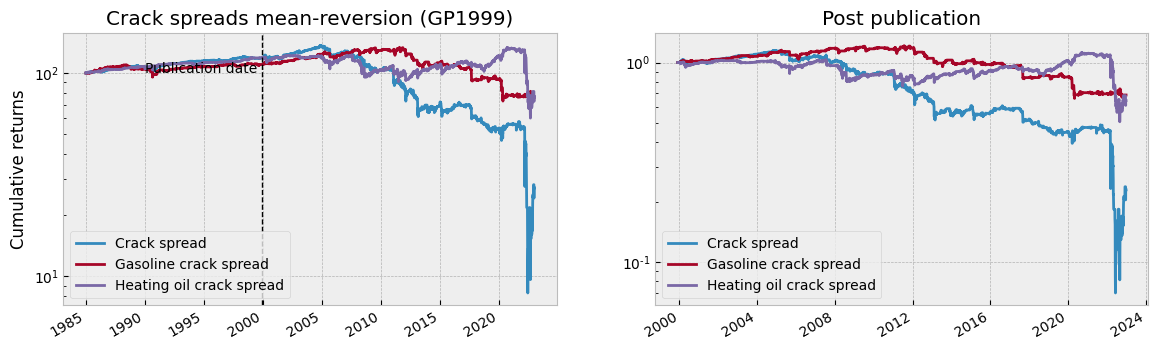

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
levels.plot(ax=ax[0], logy=True);
ax[0].set_title('Crack spreads mean-reversion (GP1999)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

levels.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Post publication');

# Reference
- Girma, P.B. and Paulson, A.S., 1999. Risk arbitrage opportunities in petroleum futures spreads. Journal of Futures Markets, 19(8), pp.931-955.

In [43]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 23-Dec-2022 06:34
